In [ ]:
#@title TENSORFLOW -  FINE TUNING PART 2

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
import numpy as np

In [ ]:
!nvidia-smi

In [ ]:
!mkdir -p extra

In [ ]:
!cd "/content/extra";touch helper_functions.py

In [ ]:
from extra.helper_functions import unzip_data,walk_through_dir,load_and_prep_image,create_tensorboard_callback

In [ ]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

In [ ]:
 unzip_data("/content/10_food_classes_10_percent.zip")

In [ ]:
walk_through_dir("10_food_classes_10_percent")

In [ ]:
train_dir =  "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test/"

In [ ]:
!ls -l "/content/10_food_classes_10_percent/train" | wc -l

In [ ]:
!ls -l "/content/10_food_classes_10_percent/test/" | wc -l

In [ ]:
# create train batch and test batch dataset

BATCH_SIZE=32
IMAGE_WIDTH=224
IMAGE_HEIGHT=224



In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    shuffle = True,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    label_mode='categorical',
    batch_size=BATCH_SIZE
)
test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    shuffle = True,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    label_mode='categorical'
)

'''
'categorical' means that the labels are encoded as a categorical vector 
(e.g. for categorical_crossentropy loss).
Found 750 files belonging to 10 classes. for train set
Found 2500 files belonging to 10 classes. for test set
if label_mode is categorical, the labels are a float32 tensor of 
shape (batch_size, num_classes), representing a one-hot encoding of the class index.

'''

In [ ]:
train_dataset

In [ ]:
#@title CLASS NAMES #url = https://keras.io/guides/transfer_learning/; https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory


In [ ]:
#@title **THIS IS KERAS FUNCTIONAL API TUTORIAL-EfficientNetB0---	224 & EfficientNet models expect their inputs to be float tensors of pixels with values in the [0-255] range. We should not normalize them**

base_model  = tf.keras.applications.EfficientNetB0(include_top=False) # include_top = False will freeze top layer fully connected layer

# freeze all layers as well

base_model.trainable=False

# 3. Create inputs into the base model
input_layer = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")
#add input to BASE MODEL!
model_layers = base_model(input_layer)

print(f"shape after base model")

averga_pool = tf.keras.layers.GlobalAveragePooling2D(name="global_average_layer")(model_layers)

#add output
output_layer = tf.keras.layers.Dense(10, activation="softmax", name="Dense_Activation_Softmax")(averga_pool)

#aggreage model
final_model = tf.keras.Model(input_layer, output_layer)

# compile
final_model.compile(
    
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics= ["accuracy"])



In [ ]:
history_0 = final_model.fit(train_dataset,
                                 epochs=10,
                                 steps_per_epoch=len(train_dataset),
                                 validation_data=test_dataset,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_dataset)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])


In [ ]:
#@title MODEL LAYER NUMBER TOGETHER WITH MODEL LAYRES

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number , layer.name)

In [ ]:
base_model.summary()

In [ ]:
#@title **MY MODEL SUMMARY**
final_model.summary()

In [ ]:
from extra.helper_functions import plot_loss_curves,pred_and_plot, walk_through_dir,unzip_data

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning/

In [ ]:
plot_loss_curves(history_0)

In [ ]:
#@title  global average pooling converts 4D tensor to 2D tensor

input_shape = (1, 4, 4, 3)
tf.random.set_seed(42)

input_tensor = tf.random.normal(input_shape)

input_global = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)

input_tensor.shape, input_global.shape

In [ ]:
#@title predict and plot
pred_and_plot(final_model, "10_food_classes_1_percent/test/chicken_wings/1010547.jpg", )

In [ ]:
#@title **TRANSFER LEARNING-FINE TUNING**

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

In [ ]:
unzip_data("10_food_classes_1_percent.zip")

In [ ]:
walk_through_dir("10_food_classes_1_percent")
'''
7 images on train set and 250 images on test set
'''

In [ ]:
IMAGE_SIZE= (224, 224)
BATCH_SIZE=32
train_dir = "/content/10_food_classes_1_percent/train/"
test_dir = "/content/10_food_classes_1_percent/test/"

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE


)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)

#Found 70 files belonging to 10 classes.
#Found 2500 files belonging to 10 classes.


In [ ]:
classes = train_data_1_percent.class_names
testClasses = test_data_1_percent.class_names

classes

In [ ]:
train_data_classes=len(train_data_1_percent.class_names)

In [ ]:
#@title  TENSORFLOW FLOW DATA AUGMENTATION STEPS
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
data_augmentation = keras.models.Sequential([
    preprocessing.RandomFlip(mode="horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2)
], name="DATA_AUGMENTATION")

In [ ]:
import random
from extra.helper_functions import display_image,augmentated_image

In [ ]:
#@title image displau
display_image(train_data_1_percent, train_dir)

In [ ]:
input_display = display_image(train_data_1_percent, train_dir)


Run the cell above a few times and you can see the different random augmentations on different classes of images. Because we're going to add the data augmentation model as a layer in our upcoming transfer learning model, it'll apply these kind of random augmentations to each of the training images which passes through it.

Doing this will make our training dataset a little more varied. You can think of it as if you were taking a photo of food in real-life, not all of the images are going to be perfect, some of them are going to be orientated in strange ways. These are the kind of images we want our model to be able to handle.

Speaking of model, let's build one with the Functional API. We'll run through all of the same steps as before except for one difference, we'll add our data augmentation Sequential model as a layer immediately after the input layer.

In [ ]:
#@title Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
input_shape = (224,224, 3)

# import model apart from last actication layer
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

#Freeze all model
base_model.trainable = False

input_layer = tf.keras.layers.Input(shape=input_shape, name="Input Layer")

## add input layer to data augmetattion sequential api as input
data_augmented = data_augmentation(input_layer)

model_init = base_model(data_augmented, training=False)
print(f"model input shape: {model_init.shape}")
model_global = tf.keras.layers.GlobalAveragePooling2D(name="Global_Average2D")(model_init)

print(f"model input shape: {model_global.shape}")

model_dense = tf.keras.layers.Dense(10, activation = "softmax", name="Dense_Layer")(model_global)

# prepare model with input and output

model_final = tf.keras.Model(input_layer, model_dense)


In [ ]:

model_final.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ["accuracy"])

In [ ]:
from extra.helper_functions import create_tensorboard_callback

In [ ]:
history_augmentated = model_final.fit(
    train_data_1_percent,
    epochs=10,
    steps_per_epoch=len(train_data_1_percent),
    validation_data = test_data_1_percent,
    validation_steps = len(test_data_1_percent),
    callbacks=[create_tensorboard_callback("transfer_learning_feature_extract",
                                             "1_percent_train_data_WithAugmentation")]
)

#TENSORBOARD **RESULTS WITH DATA AUGMENTATION - TRANSFER LEARNING FEATURE EXTRACTION**

https://tensorboard.dev/experiment/dWLM6CMtRqGydv2SmQ2FGA/

In [ ]:
! tensorboard dev upload --logdir="./transfer_learning_feature_extract/"

**Fikrat Developed Data Augmentation Layer with EfficinetB0**
Model: "model_1" 
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 DATA_AUGMENTATION (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average2D (GlobalAve  (None, 1280)             0         
 ragePooling2D)                                                  
                                                                 
 Dense_Layer (Dense)         (None, 10)                12810     
                                                                 
=================================================================
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571

In [ ]:
model_final.summary()

In [ ]:
from extra.helper_functions import plot_loss_curves 

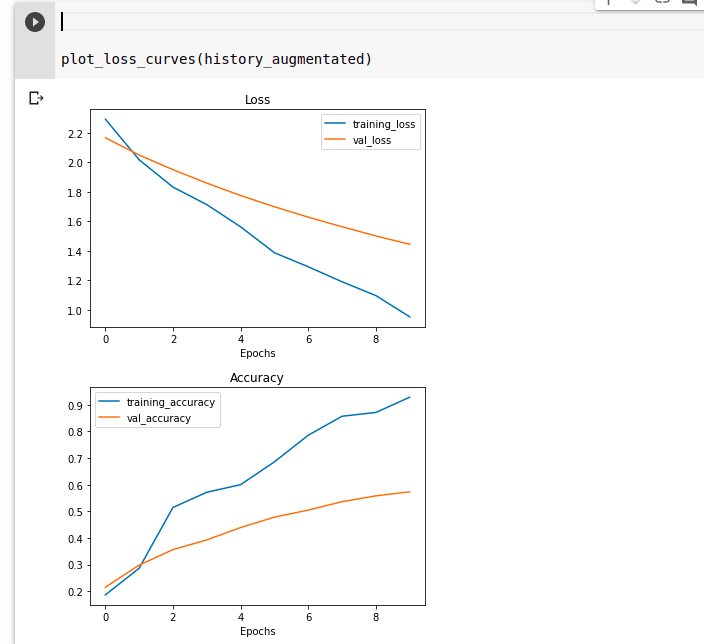

In [ ]:


plot_loss_curves(history_augmentated)

Creating a ModelCheckpoint callback
Our model is compiled and ready to be fit, so why haven't we fit it yet?

Well, for this experiment we're going to introduce a new callback, the ModelCheckpoint callback.

The ModelCheckpoint callback gives you the ability to save your model, as a whole in the SavedModel format or the weights (patterns) only to a specified directory as it trains.

This is helpful if you think your model is going to be training for a long time and you want to make backups of it as it trains. It also means if you think your model could benefit from being trained for longer, you can reload it from a specific checkpoint and continue training from there.

For example, say you fit a feature extraction transfer learning model for 5 epochs and you check the training curves and see it was still improving and you want to see if fine-tuning for another 5 epochs could help, you can load the checkpoint, unfreeze some (or all) of the base model layers and then continue training.

In fact, that's exactly what we're going to do.

But first, let's create a ModelCheckpoint callback. To do so, we have to specifcy a directory we'd like to save to.

In [ ]:
checkpoint_path = "one_percent_model_checkpoints/checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    save_freq="epoch",
    verbose=1,
    mode = "max"
)

✅ Question: What's the difference between saving the entire model (SavedModel format) and saving the weights only?

The SavedModel format saves a model's architecture, weights and training configuration all in one folder. It makes it very easy to reload your model exactly how it is elsewhere. However, if you do not want to share all of these details with others, you may want to save and share the weights only (these will just be large tensors of non-human interpretable numbers). If disk space is an issue, saving the weights only is faster and takes up less space than saving the whole model.

Time to fit the model.

Because we're going to be fine-tuning it later, we'll create a variable initial_epochs and set it to 5 to use later.

We'll also add in our checkpoint_callback in our list of callbacks.

In [ ]:
history_augmentation= model_final.fit(
    train_data_1_percent,
    epochs=10,
    steps_per_epoch=len(train_data_1_percent),
    validation_data = test_data_1_percent,
    validation_steps = len(test_data_1_percent),
    callbacks=[create_tensorboard_callback("transfer_learning_feature_extract",
                                             "1_percent_train_data_WithAugmentation"),
               checkpoint_callback])

In [ ]:
model_final.load_weights(checkpoint_path)

In [ ]:
model_loadaded_checkpoint = model_final.evaluate(test_data_1_percent)

In [ ]:
prediction_test = model_final.predict(test_data_1_percent)
prediction_test

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 Input Layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 DATA_AUGMENTATION (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 Global_Average2D (GlobalAve  (None, 1280)             0         
 ragePooling2D)                                                  
                                                                 
 Dense_Layer (Dense)         (None, 10)                12810     
                                                                 
=================================================================
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________

In [ ]:
model_final.summary()

In [ ]:
from extra.helper_functions import calculate_results


High-level example of fine-tuning an EfficientNet model. Bottom layers (layers closer to the input data) stay frozen where as top layers (layers closer to the output data) are updated during training.

So far our saved model has been trained using feature extraction transfer learning for 5 epochs on 10% of the training data and data augmentation.

This means all of the layers in the base model (EfficientNetB0) were frozen during training.

For our next experiment we're going to switch to fine-tuning transfer learning. This means we'll be using the same base model except we'll be unfreezing some of its layers (ones closest to the top) and running the model for a few more epochs.

The idea with fine-tuning is to start customizing the pre-trained model more to our own data.

🔑 Note: Fine-tuning usually works best after training a feature extraction model for a few epochs and with large amounts of data. For more on this, check out Keras' guide on Transfer learning & fine-tuning.

We've verified our loaded model's performance, let's check out its layers.


**These are layers of model which are all evaluated, with respect to Trainable or Non Trainable**
```
True
True
False
True
True
```




In [ ]:
for layer in model_final.layers:
  print(layer.trainable)



We can even check layer by layer to see if the they're trainable.

In [ ]:
for layer_number, layer in enumerate(model_final.layers):

  print(layer_number, layer.name, layer.trainable)

Beautiful. This is exactly what we're after.

Now to fine-tune the base model to our own data, we're going to unfreeze the top 10 layers and continue training our model for another 5 epochs.

This means all of the base model's layers except for the last 10 will remain frozen and untrainable. And the weights in the remaining unfrozen layers will be updated during training.

Ideally, we should see the model's performance improve.

🤔 Question: How many layers should you unfreeze when training?

There's no set rule for this. You could unfreeze every layer in the pretrained model or you could try unfreezing one layer at a time. Best to experiment with different amounts of unfreezing and fine-tuning to see what happens. Generally, the less data you have, the less layers you want to unfreeze and the more gradually you want to fine-tune.



In [ ]:
for layer_number, layer in enumerate(base_model.layers):

  print(layer_number, layer.name, layer.trainable)

**To begin fine-tuning, we'll unfreeze the entire base model by setting its trainable attribute to True. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their trainable attribute to False. Finally, we'll recompile the model.**

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable=False

In [ ]:
for layer_name, layer in enumerate(base_model.layers):
  print(layer_name, layer_number, layer.trainable)

In [ ]:
fine_tune_epochs=10


In [ ]:
model_final.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [ ]:
for layer_name, layer in enumerate(model_final.layers):
  print(layer_name, layer_number, layer.trainable)

In [ ]:
history_model = model_final.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data_1_percent,
                                validation_steps=len(test_data_1_percent),
                                callbacks=[create_tensorboard_callback("fine_tuning_transfer_learning", "fine_tuning_BaseModelEfficientB0"),
                                           checkpoint_callback])

In [ ]:
model_evaluate = model_final.evaluate(test_dataset)

In [ ]:
from extra.helper_functions import compare_historys

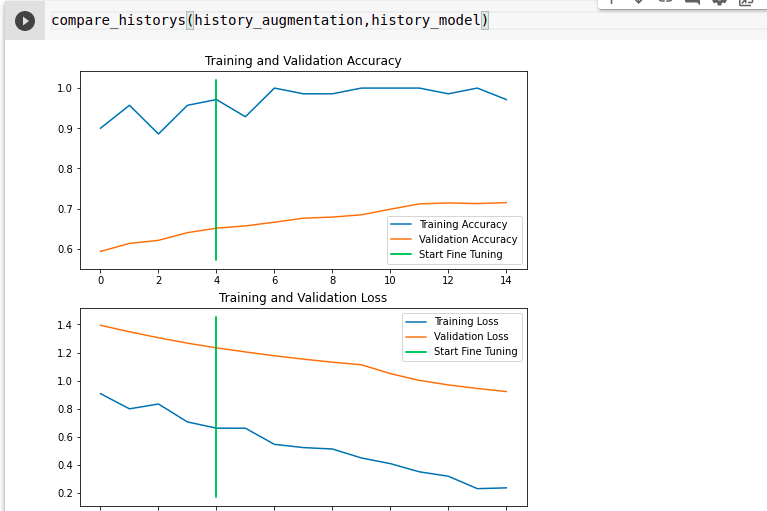

In [ ]:
compare_historys(history_augmentation,history_model)


[Tensorboard Fine Tuning-Transfer Learning](https://)https://tensorboard.dev/experiment/nDTKOuRKQxKPPd2XA8jpZA/#scalars

In [ ]:
!tensorboard dev upload --logdir ./fine_tuning_transfer_learning/